In [190]:
import pandas as pd
import numpy as np
import seaborn as sns # type: ignore
from pathlib import Path

In [191]:
CONFERENCE_PATH = Path("outputs/SIGIR2022")
authors = pd.read_csv( # type: ignore
    CONFERENCE_PATH / "authors.csv", 
    dtype={
        'author_name': str,
        'author_id': np.int64,
        'citations': np.int32,
        'paper_count': np.int32,
        'h_index': np.int32,
        'institution': str,
    }
)
authorships = pd.read_csv(CONFERENCE_PATH / "authorships.csv") # type: ignore

In [192]:
authors.head()

,author_name,author_id,citations,paper_count,h_index,institution
0,chuanqi tan,2111727840,2871,68,25,NaN
1,lei li,120975273,33,1,1,NaN
2,xiangning chen,2150931823,458,21,11,NaN
3,huajun chen,49178307,1748,79,23,NaN
4,shumin deng,152931849,1763,68,25,NaN


In [193]:
# type: ignore
co_authors = authorships.groupby('title').agg(num_coauthors=('title', 'count'))
authorships = pd.merge(authorships, co_authors, on='title')
avg_num_co_authors = pd.merge(authors, authorships, on='author_id').groupby('author_id').agg(avg_num_co_authors=('num_coauthors', 'mean'))
authors = pd.merge(authors, avg_num_co_authors, on='author_id')
authors.head()

,author_name,author_id,citations,paper_count,h_index,institution,avg_num_co_authors
0,chuanqi tan,2111727840,2871,68,25,NaN,8.000000
1,lei li,120975273,33,1,1,NaN,9.000000
2,xiangning chen,2150931823,458,21,11,NaN,9.000000
3,huajun chen,49178307,1748,79,23,NaN,9.666667
4,shumin deng,152931849,1763,68,25,NaN,9.000000


In [194]:
# Remove null author ids, which were failed matches, as we can't gather statistics for those authors
authorships = authorships[~authorships['author_id'].isna()].convert_dtypes()
authorships.head()

,title,author_name,author_position,author_id,num_coauthors
0,Hybrid Transformer with Multi-level Fusion for...,xiang chen,0,2150931823,9
1,Hybrid Transformer with Multi-level Fusion for...,ningyu zhang,1,2608639,9
2,Hybrid Transformer with Multi-level Fusion for...,lei li,2,120975273,9
3,Hybrid Transformer with Multi-level Fusion for...,shumin deng,3,152931849,9
4,Hybrid Transformer with Multi-level Fusion for...,chuanqi tan,4,2111727840,9


In [195]:
# type: ignore
# Create dataframe representing: author_id (and other info in authors df), average number of co-authors, number of papers at this conference
num_conference_papers = pd.merge(authors, authorships, on='author_id').groupby('author_id').agg(num_papers=('title', 'count'))
authors = pd.merge(authors, num_conference_papers, on='author_id')
authors.head()

,author_name,author_id,citations,paper_count,h_index,institution,avg_num_co_authors,num_papers
0,chuanqi tan,2111727840,2871,68,25,NaN,8.000000,2
1,lei li,120975273,33,1,1,NaN,9.000000,1
2,xiangning chen,2150931823,458,21,11,NaN,9.000000,1
3,huajun chen,49178307,1748,79,23,NaN,9.666667,3
4,shumin deng,152931849,1763,68,25,NaN,9.000000,1


In [196]:
authors['citations'] += 1 # so that log scale works

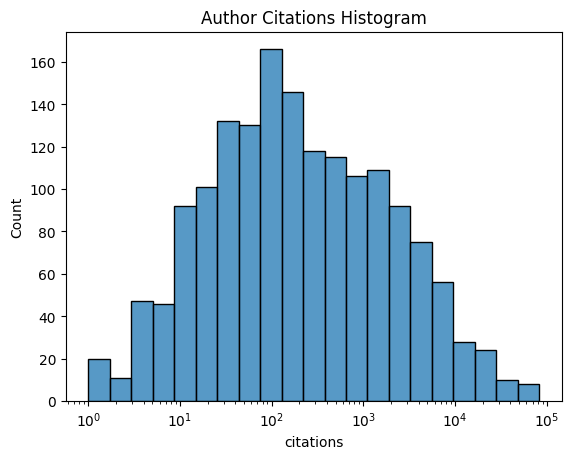

In [197]:
_ = sns.histplot(authors['citations'], log_scale=True).set_title('Author Citations Histogram')

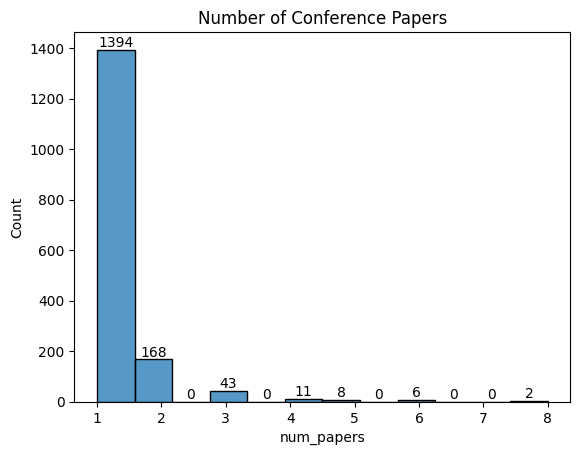

In [198]:
ax = sns.histplot(authors['num_papers'])
ax.set_title('Number of Conference Papers')
_ = ax.bar_label(ax.containers[1])

In [199]:
# Cap number of papers to 4, since the higher buckets have such low sample sizes
authors.loc[authors['num_papers'] > 4, 'num_papers'] = 4

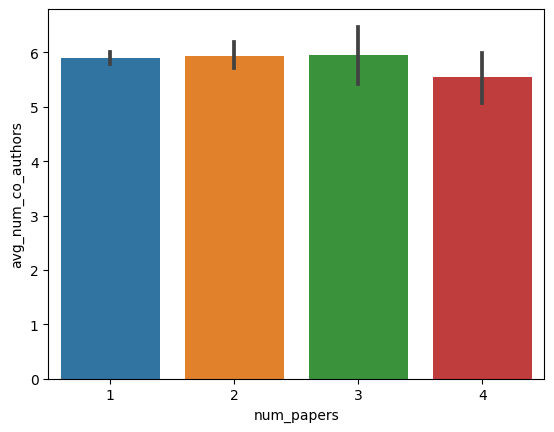

In [200]:
# Probably people with 8 papers have them with different students on each paper, decreasing the average number of co-authors
_ = sns.barplot(authors, x='num_papers', y='avg_num_co_authors')

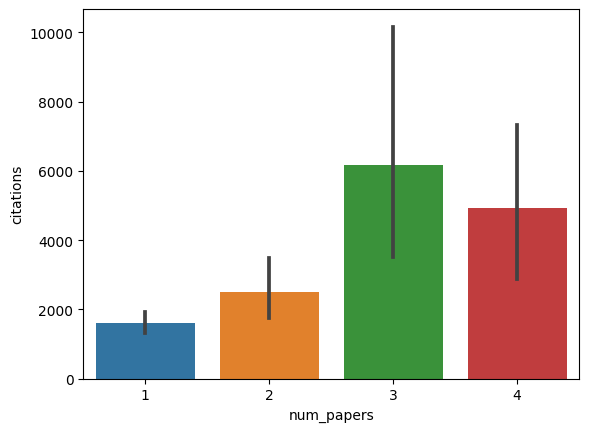

In [201]:
# I guess for large numbers of papers, there are more students with lower citations doing the work
_ = sns.barplot(authors, x='num_papers', y='citations')

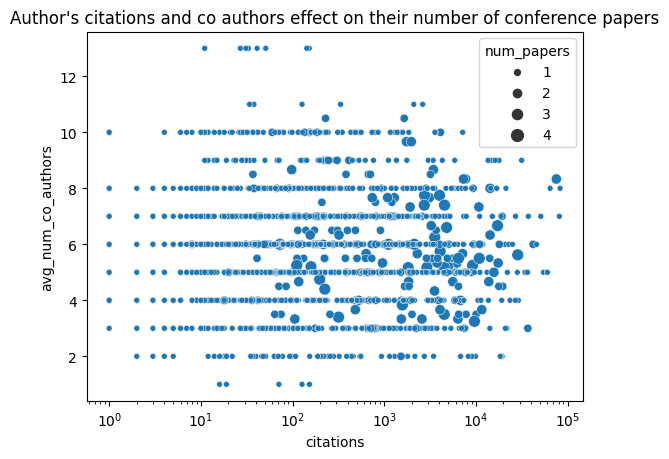

In [202]:
_ = (sns.scatterplot(authors, x='citations', y='avg_num_co_authors', size='num_papers')
     .set(xscale='log', alpha=0.8, title="Author's citations and co authors effect on their number of conference papers"))

In [203]:
authorships['relative_position'] = (authorships['author_position'] + 1) / authorships['num_coauthors']
seniority_index = authorships.groupby('author_id').agg(seniority_index=('relative_position', 'mean'))
seniority_index = np.ceil(10*seniority_index) # bin the positions so they're easier to visualise
authors = pd.merge(authors, seniority_index, on='author_id').astype({'seniority_index': 'float'})

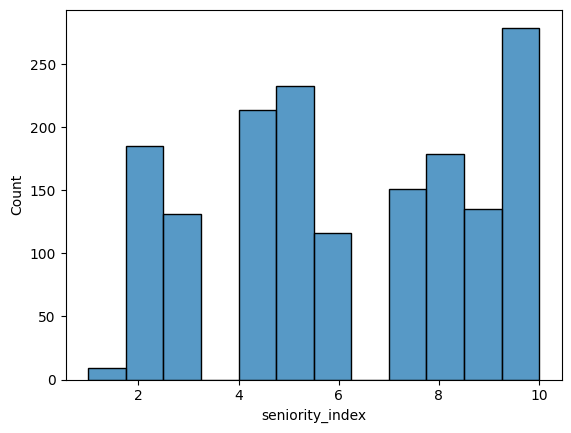

In [204]:
_ = sns.histplot(authors['seniority_index'].astype('float'))

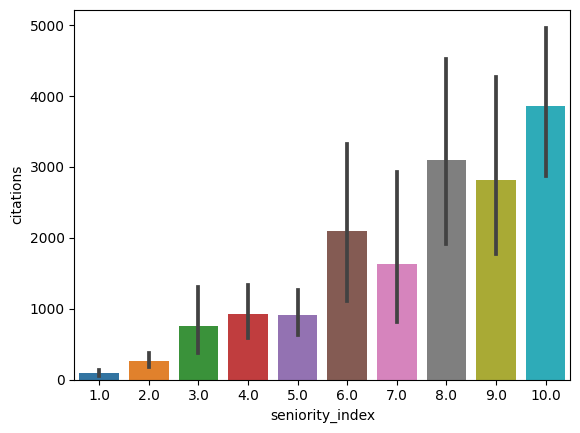

In [209]:
_ = sns.barplot(authors, y='citations', x='seniority_index')